In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
run = 'one_gravity_wave'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

nx = 200
ny = 50
nt = 1000

picture_frequency = 0
output_frequency = 20
diagnostic_frequency = output_frequency

dx = 10e3
dy = dx

grav = 9.81
rho = np.array([1024.])
nz = rho.size

H0 = 1000.
cph = np.sqrt(grav*H0)
dist = dt*nt * cph
dt  = 0.1*dx/np.sqrt(grav*H0)

nspx = 1
nspy = 1
epsab = 0.01

kh = 1000.
Ah = kh

f0 = 1e-4
beta = 0.*1e-11

do_momentum_advection = False
do_momentum_diffusion = False
do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_height_diffusion = False

In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
fac_H0 = 1.
#ho0 = 0.01*(Xt-Lx/2.)/Lx
#ho0 = H0+0.1*np.sin(Xt/(Lx+dx)*2*np.pi*2)
#eta0[0,:,:] = 0.1*np.exp(-((Xt-0.5*Lx)**2)/(1.e-3*(Lx**2+Ly**2)))
k0 = 2 * 2*np.pi/(Lx+dx)
eta0[0,:,:] = 0.1*np.sin(k0*Xt)
eta0[1,:ny//2,:] = -H0
eta0[1,ny//2:,:] = -H0*fac_H0
Lr = np.sqrt(grav*H0)/f0
om0 = np.sqrt(f0**2*(1+Lr**2*k0**2))
uo0 = 0.1*grav*k0/om0 * np.sin(k0*Xt)
uo0 = uo0[np.newaxis,:,:]
ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

#uo0 = cph + 0.*Xu
#uo0 = uo0[np.newaxis,:,:]

#maskt0[:,0,:] = 0.
#maskt0[:,-1,:] = 0.
#maskt0[:,ny//2-1:ny//2+1,:] = 0.

#eta_bot0[:,:ny//2,:] = H0
#eta_bot0[:,ny//2:,:] = H0
#H0 = 0.

#ix = np.array([nx//2, nx//2])
#iy = np.array([1*ny//4, 3*ny//4])
ix = np.array([nx//2])
iy = np.array([1*ny//4])

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

ll =    980/  1000, Total run time: 0.19min, done at 2022-08-26 13:03:43.781882, ho.sum = 1.1e+07, ke.sum = 2.5e-01, cflu = 9.8e-06, cflv = 1.2e-07
--- All done! ---
Total run time: 0.19min, done at 2022-08-26 13:03:43.708676
------


## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [9]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    ds = xr.open_mfdataset(f'{path_data}/{file_prfx}_????.nc', **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/one_gravity_wave//shallowpy_combined.nc
CPU times: user 1.39 s, sys: 493 ms, total: 1.89 s
Wall time: 1.46 s


## Plot overview

In [10]:
nps = ds.time.size
nps

50

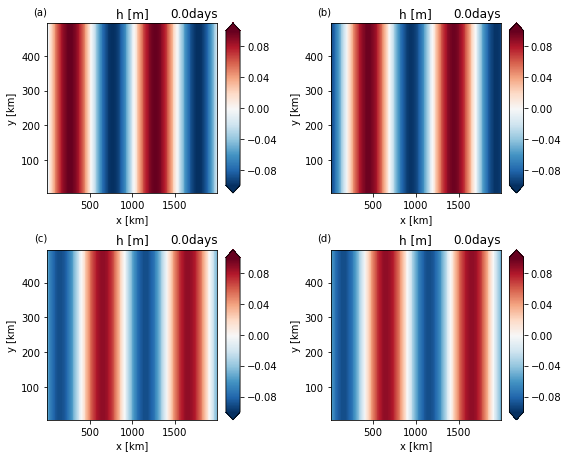

In [11]:
# prepare the animation
iz = 0
steps = [1, 10, 20, 20]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=1., fig_size_fac=1.5,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds['ho'][ll,iz,:,:].compute()
    clim = 0.1
    hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
    ax.set_title('h [m]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

## Make an animation

In [12]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/shallowpy_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

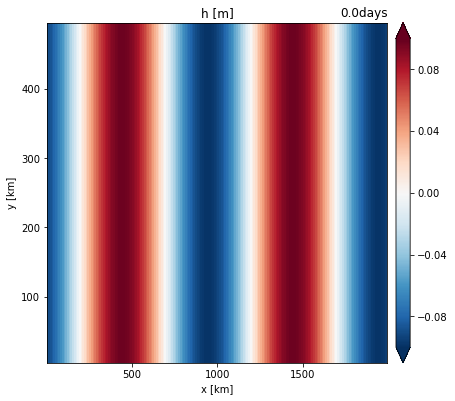

In [13]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=1.00, fig_size_fac=3, axlab_kw=None,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['ho'][ll,iz,:,:].compute()
clim = 0.1
hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
ax.set_title('h [m]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

In [14]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    hm[0].set_array(data.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [15]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/one_gravity_wave///one_gravity_wave.mp4
CPU times: user 3.39 s, sys: 193 ms, total: 3.58 s
Wall time: 3.8 s


## Showing the animation

In [16]:
%%time
HTML(ani.to_jshtml())

CPU times: user 4.59 s, sys: 156 ms, total: 4.74 s
Wall time: 5.15 s
